<h2>Importing Data<h2>

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
from helper import plot_x_days


In [129]:
df1 = pd.read_json('./Datasets/generated_data_Economics.json')
df2 = pd.read_csv('./Datasets/VOO.csv')

<h3>Preparing The Stock Price Data<h3>

In [130]:
df2['list_time'] = df2['Unnamed: 0'].str.split(" ")
df2['date'] = df2['list_time'].str[0]
df2['date'] =  pd.to_datetime(df2['date'])
df2['time'] = df2['list_time'].str[1].str.split("-").str[0]
df2.rename(columns={'Adj Close': 'price'}, inplace=True)
df2.head(5)

,Unnamed: 0,price,list_time,date,time
0,2022-08-29 09:30:00-04:00,369.648010,"[2022-08-29, 09:30:00-04:00]",2022-08-29,09:30:00
1,2022-08-29 09:31:00-04:00,369.799988,"[2022-08-29, 09:31:00-04:00]",2022-08-29,09:31:00
2,2022-08-29 09:33:00-04:00,370.220001,"[2022-08-29, 09:33:00-04:00]",2022-08-29,09:33:00
3,2022-08-29 09:34:00-04:00,370.549988,"[2022-08-29, 09:34:00-04:00]",2022-08-29,09:34:00
4,2022-08-29 09:35:00-04:00,370.299988,"[2022-08-29, 09:35:00-04:00]",2022-08-29,09:35:00


In [131]:
df2 = df2[['date', 'time', 'price']]
df2 = df2.groupby('date').agg(list)
df2['time_price'] = df2.apply(lambda row : dict(zip(row[0],row[1])), axis=1)
df2.reset_index(inplace=True)
df2.head()

,date,time,price,time_price
0,2022-08-29,"[09:30:00, 09:31:00, 09:33:00, 09:34:00, 09:35...","[369.6480102539063, 369.7999877929688, 370.220...","{'09:30:00': 369.6480102539063, '09:31:00': 36..."
1,2022-08-30,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[371.2200012207031, 370.760009765625, 371.0400...","{'09:30:00': 371.2200012207031, '09:31:00': 37..."
2,2022-08-31,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.0400085449219, 367.0700073242188, 366.660...","{'09:30:00': 367.0400085449219, '09:31:00': 36..."
3,2022-09-01,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[361.5299987792969, 360.8349914550781, 360.959...","{'09:30:00': 361.5299987792969, '09:31:00': 36..."
4,2022-09-02,"[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.3999938964844, 366.8800048828125, 366.709...","{'09:30:00': 367.3999938964844, '09:31:00': 36..."


<h3>Merging The Sentiment Data And Stock Price Data<h3>

In [132]:
df1.reset_index(inplace=True)
df1.rename(columns={'index': 'date'}, inplace=True)
df1.head()

,date,Economics
0,2022-08-30,"{'10:58:00': {'polarity': 0.0, 'subjectivity':..."
1,2022-08-31,"{'00:00:00': {'polarity': 0.0, 'subjectivity':..."
2,2022-09-01,"{'00:18:00': {'polarity': 0.0, 'subjectivity':..."
3,2022-09-02,"{'00:01:00': {'polarity': 0.8, 'subjectivity':..."
4,2022-09-03,"{'00:02:00': {'polarity': 0.0, 'subjectivity':..."


In [133]:
df = pd.merge(df1, df2, how='outer', on='date')
df['date'] =  pd.to_datetime(df['date'])
df.dropna(inplace=True)
df.head()

,date,Economics,time,price,time_price
0,2022-08-30,"{'10:58:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[371.2200012207031, 370.760009765625, 371.0400...","{'09:30:00': 371.2200012207031, '09:31:00': 37..."
1,2022-08-31,"{'00:00:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.0400085449219, 367.0700073242188, 366.660...","{'09:30:00': 367.0400085449219, '09:31:00': 36..."
2,2022-09-01,"{'00:18:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[361.5299987792969, 360.8349914550781, 360.959...","{'09:30:00': 361.5299987792969, '09:31:00': 36..."
3,2022-09-02,"{'00:01:00': {'polarity': 0.8, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.3999938964844, 366.8800048828125, 366.709...","{'09:30:00': 367.3999938964844, '09:31:00': 36..."
7,2022-09-06,"{'00:00:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[362.0299987792969, 361.6700134277344, 361.609...","{'09:30:00': 362.0299987792969, '09:31:00': 36..."


<h3>Determining Percent Change In Price<h3>

In [134]:
def generate_price_dif(row):
    prices = np.asarray(row['price'])
    price_shift = np.asarray(row['price'][1:] + row['price'][0:1])
    delta_price = prices-price_shift
    percent_change = delta_price/prices
    return delta_price

df['price_diff']  = df.apply(lambda row: generate_price_dif(row), axis=1)
df['percent_change'] = df.apply(lambda row: (row['price_diff']/np.asarray(row['price'])) * 100, axis= 1)
df.head()

,date,Economics,time,price,time_price,price_diff,percent_change
0,2022-08-30,"{'10:58:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[371.2200012207031, 370.760009765625, 371.0400...","{'09:30:00': 371.2200012207031, '09:31:00': 37...","[0.459991455078125, -0.279998779296875, -0.119...","[0.1239134350426997, -0.07552022114625456, -0...."
1,2022-08-31,"{'00:00:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.0400085449219, 367.0700073242188, 366.660...","{'09:30:00': 367.0400085449219, '09:31:00': 36...","[-0.029998779296931843, 0.41000366210943184, -...","[-0.008173163306054224, 0.11169631240050933, -..."
2,2022-09-01,"{'00:18:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[361.5299987792969, 360.8349914550781, 360.959...","{'09:30:00': 361.5299987792969, '09:31:00': 36...","[0.69500732421875, -0.125, 0.3800048828125, 0....","[0.1922405682973575, -0.034641873144268434, 0...."
3,2022-09-02,"{'00:01:00': {'polarity': 0.8, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[367.3999938964844, 366.8800048828125, 366.709...","{'09:30:00': 367.3999938964844, '09:31:00': 36...","[0.519989013671875, 0.170013427734375, 0.19998...","[0.14153212365550089, 0.04634033620575209, 0.0..."
7,2022-09-06,"{'00:00:00': {'polarity': 0.0, 'subjectivity':...","[09:30:00, 09:31:00, 09:32:00, 09:33:00, 09:34...","[362.0299987792969, 361.6700134277344, 361.609...","{'09:30:00': 362.0299987792969, '09:31:00': 36...","[0.3599853515625, 0.060028076171875, 0.1149902...","[0.09943522712932877, 0.016597471159678894, 0...."


<h2>Visualizing Trends In News Sentiment and Stock Prices</h2>

<p>Visualizing the data should reveal trends in the prices that make be unintuitive given large sets of numbers. This should provide us with a solid basis for attempting to explore correlations in stock prices and news sentiment.</p>

<h3>Plotting Sentiment Versus Price</h3>

<p>We begin by exploring the intesnity of sentiment per minute with data to the daily graph of our given stock.</p>

AttributeError: 'numpy.int64' object has no attribute 'year'

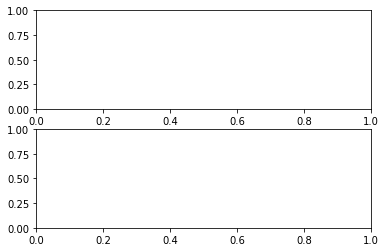

In [142]:
plot_x_days(1,'Economics', df)

<p>Now lets explore the relationship between change in price and the sentiment intensities</p>

In [ ]:

def plot_change(x, dataframe, subplot = plt):
    lst = []
    times = []
    for i in range(x):
        date = dataframe.iloc[i]['date']
        for item in dataframe.iloc[i]['time']:
            time = item.split(":")
            times.append(datetime.datetime(date.year,date.month,date.day,int(time[0]),int(time[1])))
        lst += list(dataframe.iloc[i]['percent_change'])

    subplot.plot(times, lst)
    #subplot.ylim(-.3, 1)

<h3>Initial Hypothesis</h3>
<p>blah blah blah</p>

<h2>Markov Chains<h2>

<h3>Nth Degree Markov Chains<h3>

<h3>Optimizing Nth Degree Markov Chains<h3>

<h2>Deep Neural Network<h2>

<h2>LSTM Networks<h2>